<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional


In [2]:
tf.config.list_physical_devices('GPU')

[]

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data = pd.read_csv("ner_datasetreference.csv", encoding="latin1")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
data.nunique()

Sentence #    47959
Word          35177
POS              42
Tag              17
dtype: int64

In [5]:
data["Tag"].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
data.groupby("Tag")[["Word", "POS"]].count()

,Word,POS
Tag,,
B-art,402,402
B-eve,308,308
B-geo,37644,37644
B-gpe,15870,15870
B-nat,201,201
B-org,20143,20143
B-per,16990,16990
B-tim,20333,20333
I-art,297,297


In [7]:
data["POS"].unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

In [8]:
data.isna().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [9]:
data[data["Word"].isna()].index.values

array([ 197658,  256026,  257069,  571211,  613777,  747019,  901758,
        903054,  944880, 1003438], dtype=int64)

In [10]:
idxs = data[data["Word"].isna()].index.values[0]
data.loc[idxs - 4:idxs + 4]

,Sentence #,Word,POS,Tag
197654,NaN,before,IN,O
197655,NaN,their,PRP$,O
197656,NaN,pardons,NNS,O
197657,NaN,.,.,O
197658,Sentence: 9047,NaN,NN,O
197659,NaN,of,IN,O
197660,NaN,the,DT,O
197661,NaN,32,CD,O
197662,NaN,freed,VBN,O


In [11]:
data.loc[data[data["Word"].isna()].index.values]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


In [12]:
data["Sentence #"] = data["Sentence #"].ffill()
data["Word"] = data["Word"].bfill()
data.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [13]:
"Sentence: 123"[10:]

'123'

In [14]:
data["Sentence #"] = data["Sentence #"].apply(lambda x: x[10:]).astype(int)

In [15]:
words = data["Word"].unique().tolist()
words.append("ENDPAD")
num_words = len(words)

In [16]:
tags = data["Tag"].unique().tolist()
num_tags = len(tags)

In [17]:
num_words, num_tags

(35178, 17)

In [18]:
data['Word'].value_counts().nlargest(20)

Word
the     52573
.       47761
,       32754
of      26364
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
have     5485
with     5381
said     5321
was      4878
says     4640
Name: count, dtype: int64

In [19]:
data.sample(7)

,Sentence #,Word,POS,Tag
155552,7087,may,MD,O
142415,6486,is,VBZ,O
454967,20803,the,DT,O
41871,1879,it,PRP,O
755798,34551,.,.,O
348068,15919,.,.,O
713985,32630,on,IN,O


### Task 3: Retrieve Sentences and Corresponsing Tags

In [20]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [21]:
getter = SentenceGetter(data)
sentences = getter.sentences

C:\Users\dotpo\AppData\Local\Temp\ipykernel_14580\383738205.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [22]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [23]:
# Only positive int must be
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

 Distibution of the len of the sentences

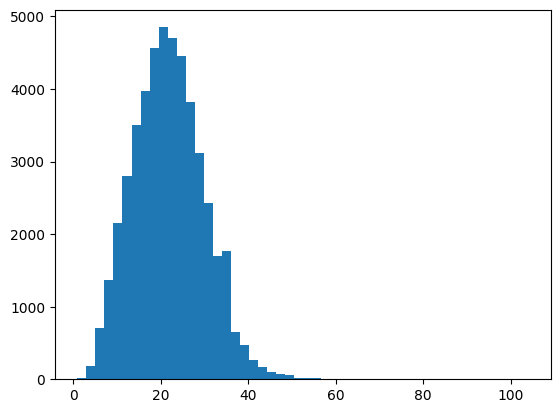

In [24]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [25]:
max_len = 50
X = [[word2idx[w[0]] for w in s]
        for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s]
        for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [26]:
X[0]

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    10,    16,     2,
          17,    18,    19,    20,    21,    22, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177])

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [29]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [46]:
import tensorflow.compat.v1 as K
# K.disable_v2_behavior()
def ignore_accuracy_of_class(class_to_ignore=0):
    def ignore_acc(y_true, y_pred):
        y_true_class = K.math.argmax(y_true, axis=-1)
        y_pred_class = K.math.argmax(y_pred, axis=-1)

        ignore_mask = K.cast(K.not_equal(y_pred_class, class_to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = tf.math.reduce_sum(matches) / K.maximum(tf.math.reduce_sum(ignore_mask), 1)
        return accuracy

    return ignore_acc

In [47]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[ignore_accuracy_of_class()])

### Task 7: Train the Model

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [49]:

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "C:\Users\dotpo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\dotpo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dotpo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\dotpo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\dotpo\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dotpo\AppData\Local\Temp\ipykernel_14580\1531157134.py", line 7, in <module>
      history = model.fit(
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "d:\Projects\PythonProjects\GLST\Task2\.venv_tf\lib\site-packages\keras\metrics\base_metric.py", line 700, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\dotpo\AppData\Local\Temp\ipykernel_14580\1923329056.py", line 9, in ignore_acc
      matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
Node: 'Equal'
Incompatible shapes: [32] vs. [32,50]
	 [[{{node Equal}}]] [Op:__inference_train_function_17805]

### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 3s 11ms/step - loss: 0.0485 - accuracy: 0.9855


[0.04852646216750145, 0.9854649901390076]

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 362ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung           O	O
Sung         